In [1]:
import os 
from random import randint
from datetime import datetime
from pyvi import ViTokenizer
from gensim import corpora, matutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
import pickle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, svm
from sklearn.model_selection import GridSearchCV, KFold
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec

from file_loader import FileStore, FileReader, DataLoader
from preprocessing import *
import const

In [2]:
dataLoader = DataLoader(const.DATA_PATH)
data = dataLoader.get_json()

fileReader = FileReader('./data/vietnamese-stopwords.txt')
stopwordLst = fileReader.read_stopwords()

In [3]:
features = []
labels = []
for d in data:
    features.append(d['content'])
    labels.append(d['category'])

In [4]:
label_dict = dict(
                    zip(
                        sorted(set(labels), key=labels.index), 
                        range(len(labels))
                        )
                )
label_dict

{'Chinh tri Xa hoi': 0,
 'Doi song': 1,
 'Khoa hoc': 2,
 'Kinh doanh': 3,
 'Phap luat': 4,
 'Suc khoe': 5,
 'The gioi': 6,
 'The thao': 7,
 'Van hoa': 8,
 'Vi tinh': 9}

In [5]:
label_indices = [label_dict[label] for label in labels]

In [6]:
features = [processing(article, stopwordLst) for article in features]

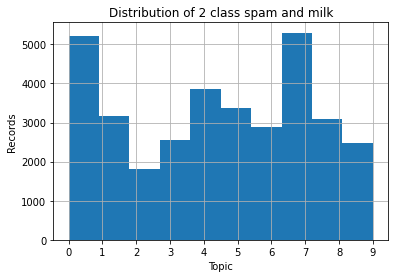

In [7]:
label_series = pd.Series(label_indices)

label_series.hist(bins=10)
plt.xticks(range(10))

plt.ylabel('Records')
plt.xlabel('Topic')
plt.title('Distribution of 2 class spam and milk')
plt.show()

In [8]:
def train_word2vec(sentences):
    w2v_model = Word2Vec(
        sentences,
        vector_size=300,
        window=3,
        min_count=1,
        sg= 1, # Training algorithm: 1 for skip-gram; otherwise CBOW.
        workers=4,
        seed = 42,
        epochs =100)
    return w2v_model

In [9]:
sentences = [row.strip().split(" ") for row in features]
print(sentences[0])
word2vec_model = train_word2vec(sentences)
print(len(word2vec_model.wv))


['thành_lập', 'dự_án', 'policy', 'phòng_chống', 'hivaids', 'vn', 'nlđ', 'quỹ', 'khẩn_cấp', 'aids', 'hoa', 'kỳ', 'thành_lập', 'dự_án', 'policy', 'vn', 'cam_kết', 'chính_phủ', 'nhân_dân', 'vn', 'đối_phó_hivaids', 'dự_án', 'nhiệm_vụ', 'cải_thiện', 'công_tác', 'phòng_chống', 'hivaids', 'thông_qua', 'lĩnh_vực', 'xây_dựng', 'chính_sách', 'rà_soát', 'văn_bản', 'pháp_luật', 'xây_dựng', 'chiến_lược', 'quảng_bá', 'xây_dựng', 'chương_trình', 'đào_tạo', 'phòng_chống', 'hivaids', 'kế_hoạch', 'bố_trí', 'nguồn_lực', 'huấn_luyện', 'nghiên_cứu', 'phương_tiện', 'truyền_thông', 'đại_chúng', 'tổ_chức', 'hoạt_động', 'kỳ_thị', 'phân_biệt', 'đối_xử', 'hivaids', 'ttxvn', 'dự_án', 'policy', 'công_tác', 'truyền_thông', 'phòng_chống', 'hivaids', 'coi', 'biện_pháp', 'tích_cực', 'hữu_hiệu', 'phòng_chống', 'hiệu_quả', 'hivaids', 'dự_án', 'policy', 'tổ_chức', 'hoạt_động', 'nâng', 'nhận_thức', 'trách_nhiệm', 'công_tác', 'chỉ_đạo', 'phòng_chống', 'hivaids']
101639


In [26]:
def average(lst):
    return sum(lst) / len(lst)

In [24]:
lengths = [len(i) for i in sentences]

In [27]:
average(lengths)

183.70677448976568

In [10]:
word2vec_feature = []
for tweet in sentences:
    average_vec = np.zeros(300)
    for word in tweet:
        if word in word2vec_model.wv:
            average_vec += (word2vec_model.wv[word] / len(tweet))
        else:
            pass
    word2vec_feature.append(average_vec)

In [11]:
len(word2vec_feature)

33759

In [12]:
len(label_indices)

33759

In [13]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    word2vec_feature, label_indices, 
    test_size=test_ratio,
    stratify=label_indices
)

In [14]:
def optimize_model_parameter(model, X_train, Y_train):
    '''
    Perform hyper parameter tuning for model
    '''
    best_model = model.fit(X_train, Y_train)
    #print(svm_grid_model.best_estimator_) 
    
    # Estimate the best accuracy
    train_accuracy = best_model.best_score_ *100
    print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )
    return best_model

def evaluate_model(model, X_test, Y_test):
    '''
    Initial evaluate model on test set
    '''
    # Predict topic indices in x_test
    Y_test_hat = model.predict(X_test)

    # Estimate the testing accuracy
    test_accuracy = metrics.accuracy_score(Y_test, Y_test_hat)*100
    print(metrics.classification_report(Y_test, Y_test_hat))
    print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
    return test_accuracy

## Naive bayes

In [15]:
from sklearn.naive_bayes import *
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

evaluate_model(nb_clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.46      0.94      0.62      1044
           1       0.79      0.80      0.79       632
           2       1.00      0.27      0.43       364
           3       0.89      0.53      0.67       510
           4       0.92      0.75      0.82       774
           5       0.85      0.82      0.84       677
           6       0.93      0.73      0.82       579
           7       0.99      0.87      0.92      1060
           8       0.90      0.80      0.85       616
           9       0.98      0.73      0.84       496

    accuracy                           0.77      6752
   macro avg       0.87      0.72      0.76      6752
weighted avg       0.84      0.77      0.78      6752

Accuracy for our testing dataset with tuning is : 76.81%


76.8068720379147

## SVM

In [16]:
def get_SVM_model():
    '''
    Get linear SVM model and list of parameters
    '''
    # Initialize SVM model as a classifier
    svm_model = svm.SVC(probability=True) 

    # Define config for params
    param_grid = {'C': [50, 100, 200], 
                  'kernel': ['linear', 'rbf']} 

    # Perform Grid search
    grid = GridSearchCV(
        svm_model, 
        param_grid, 
        refit = True, 
        verbose = 3, 
        cv=5,
        n_jobs=-1
    )
    
    return grid

In [17]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, x_train, y_train)
# Classifier pipeline

# Predict topic indices in x_test

# Evaluate on test set
evaluate_model(optimized_model, x_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy for our training dataset with tuning is : 89.88%
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1044
           1       0.86      0.85      0.85       632
           2       0.81      0.85      0.83       364
           3       0.90      0.88      0.89       510
           4       0.92      0.91      0.91       774
           5       0.92      0.93      0.92       677
           6       0.93      0.91      0.92       579
           7       0.98      0.98      0.98      1060
           8       0.94      0.92      0.93       616
           9       0.94      0.93      0.94       496

    accuracy                           0.91      6752
   macro avg       0.90      0.90      0.90      6752
weighted avg       0.91      0.91      0.91      6752

Accuracy for our testing dataset with tuning is : 90.55%


90.55094786729858

In [18]:
evaluate_model(optimized_model, x_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1044
           1       0.86      0.85      0.85       632
           2       0.81      0.85      0.83       364
           3       0.90      0.88      0.89       510
           4       0.92      0.91      0.91       774
           5       0.92      0.93      0.92       677
           6       0.93      0.91      0.92       579
           7       0.98      0.98      0.98      1060
           8       0.94      0.92      0.93       616
           9       0.94      0.93      0.94       496

    accuracy                           0.91      6752
   macro avg       0.90      0.90      0.90      6752
weighted avg       0.91      0.91      0.91      6752

Accuracy for our testing dataset with tuning is : 90.55%


90.55094786729858

## MLP

In [19]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(512,256,128), activation='relu', random_state=1, max_iter=300)
mlp_clf.fit(x_train, y_train)

evaluate_model(mlp_clf, x_test, y_test)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1044
           1       0.85      0.87      0.86       632
           2       0.86      0.79      0.82       364
           3       0.89      0.85      0.87       510
           4       0.86      0.93      0.89       774
           5       0.93      0.92      0.92       677
           6       0.94      0.87      0.90       579
           7       0.98      0.98      0.98      1060
           8       0.94      0.93      0.93       616
           9       0.92      0.96      0.94       496

    accuracy                           0.90      6752
   macro avg       0.90      0.89      0.90      6752
weighted avg       0.90      0.90      0.90      6752

Accuracy for our testing dataset with tuning is : 90.15%


90.15106635071089